<a href="https://colab.research.google.com/github/jtfreitas/NN_DL/blob/main/HW2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q optuna
!pip install -q PyQt5
!wget -q -O vae_tools.py https://raw.githubusercontent.com/jtfreitas/NN_DL/main/HW2/vae_tools.py

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import random
from tqdm import tqdm
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision import utils as vutils
import optuna

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from matplotlib.ticker import MaxNLocator
from matplotlib import cm

import json
#Custom module with class definitions and model training utilities
#in order to keep notebook as procedural as possible
import vae_tools as vt

seed = 69420

# Use GPU if available
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"Device in use: {device}")

random.seed(seed)
torch.manual_seed(seed)
print(f"Random seed: {seed}")

Device in use: cuda
Random seed: 69420


In [ ]:
#Load FashionMNIST datasets into memory

data_dir = 'dataset'

train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



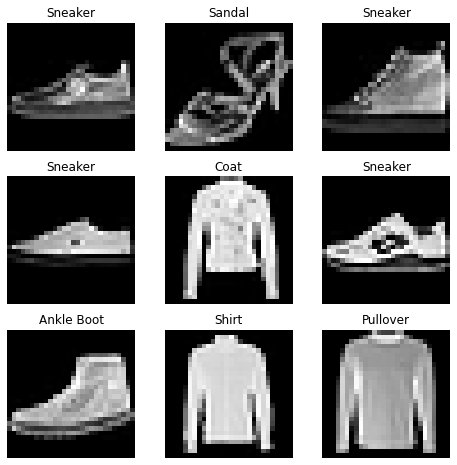

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
    }
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [ ]:
# In this case the train_transform and test_transform are the same, 
# but we keep them separate for potential future updates
MNIST_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0, 1)
])
### Define dataloaders
train_dataloader = DataLoader(train_dataset,
                            batch_size=256, shuffle=True, num_workers=2)
test_dataloader  = DataLoader(test_dataset,
                            batch_size=256, shuffle=False)

# Include a subset used only for hyperparameter tuning to speed up process
HP_search_subset = torch.utils.data.Subset(train_dataset,
                                           list(range(len(train_dataset)//5 )))
HP_search_dataloader = DataLoader(HP_search_subset,
                                  batch_size = 120, shuffle = True)


# Set the train, test and subset transform
train_dataset.transform = MNIST_transform
test_dataset.transform = MNIST_transform
HP_search_subset.transform = MNIST_transform

# Show shapes of the data for quality control
batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


In [ ]:
def AE_objective(trial):
    """
    Performs a Bayesian-like hyperparameter search, using optuna's TPESampler.
    This generally allows a more thorough search compared to completely random
    sampling methods, while saving computation time compared to a complete grid
    search, especially considering the large range of filters considered.
    Overall, it's a good compromise between the certainty of grid-search and
    the efficiency of a random search.

    The best model is chosen based on the test data loss after five epochs.
    """

    # Parameters in the search include number of filters, size of the first
    # dense layer, shape of latent space, optimizer type, and finally its 
    # respective learning rate.
    params = {
        'conv1': {'filters': trial.suggest_int('filters1', 4, 16),
                  'kernel': 3,
                  'stride': 2,
                  'padding': 1},
        'conv2': {'filters': trial.suggest_int('filters2', 16, 32),
                  'kernel': 3,
                  'stride': 2,
                  'padding': 1},
        'conv3': {'filters': trial.suggest_int('filters3', 32, 64),
                  'kernel': 3,
                  'stride': 2,
                  'padding': 0},
        'lin1': trial.suggest_int('lin1', 64, 128),
        'latent_space': trial.suggest_int('latent_space', 2, 20)
    }

    model = vt.Autoencoder(28, params, device)
    model.to(device)

    lr = trial.suggest_float('lr', 1e-5, 5e-4, log=True)
    params_to_optimize = [
        {'params': model.parameters()},
    ]
    optim_type = trial.suggest_categorical(
        'optimizer', ['Adam', 'Adagrad', 'AdamW'])
    optim = getattr(torch.optim, optim_type)(params_to_optimize, lr=lr)
    loss_fn = torch.nn.MSELoss()
    best_loss = vt.train_AE(
        model, 5, HP_search_dataloader, loss_fn, optim, device, verbose=False
        )[0] 
    # Choose only the [0]th element returned by train_AE, second corresponds
    # to the training epoch of the lowest loss.

    return best_loss

In [ ]:
optuna.logging.set_verbosity(optuna.logging.FATAL) # Disable optuna's verbose logging
study = optuna.create_study(direction='minimize')  # Goal is to minimize the loss
study.optimize(AE_objective, n_trials = 20)        # 20 different models are tested
best_results = study.best_trial
print(f"Best result achieved in trial {best_results.number}"
      f" with a loss of {best_results.value}"
      f"\nwith parameters:")

for key, value in best_results.params.items():
    print(f"{key} : {value}", end='\n')

with open('best_params.json', 'w') as f:
    json.dump(best_results.params, f)

Best result achieved in trial 17 with a loss of 0.030468057841062546
with parameters:
filters1 : 7
filters2 : 32
filters3 : 43
lin1 : 87
latent_space : 15
lr : 0.0003155570783221741
optimizer : AdamW


In [ ]:
#Format the parameters according to the structure of the autoencoder
with open('best_params.json', 'r') as f:
    params_dict = json.load(f)
best_params = {
    'conv1': {'filters': params_dict['filters1'],
                'kernel': 3,
                'stride': 2,
                'padding': 1},
    'conv2': {'filters': params_dict['filters2'],
                'kernel': 3,
                'stride': 2,
                'padding': 1},
    'conv3': {'filters': params_dict['filters3'],
                'kernel': 3,
                'stride': 2,
                'padding': 0},
    'lin1': params_dict['lin1'],
    'latent_space': params_dict['latent_space']
}

#Instantiate the autoencoder, set up torch loss and optimizer
best_AE = vt.Autoencoder(28, best_params, device)

loss_fn = torch.nn.MSELoss()
params_to_optimize = [
    {'params': best_AE.parameters()},
]

optim = getattr(torch.optim, study.best_params['optimizer'])(
    params_to_optimize, lr=study.best_params['lr'], weight_decay=1e-5)

best_AE.to(device)
loss_fn.to(device)

MSELoss()

K-fold cross-validation

In [ ]:
k_folds = 6
num_epochs = 20
cv_losses = vt.CV_AE(
    k_folds, best_AE,
    num_epochs, train_dataloader, loss_fn, optim, device)

Fold 1/6...	Done.
Fold 2/6...	Done.
Fold 3/6...	Done.
Fold 4/6...	Done.
Fold 5/6...	Done.
Fold 6/6...	Done.


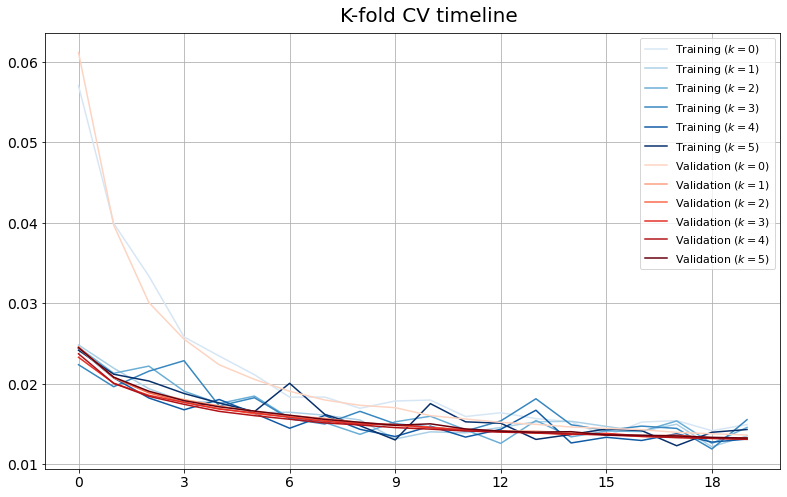

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12, 7),
                       tight_layout=dict(rect=(0,0,.92,.95))
                       )

for loss, loss_type, cmap in zip(cv_losses,
                                 ['Training', 'Validation'],
                                 ['Blues', 'Reds']):
    cmap = cm.get_cmap(cmap)
    for fold in range(k_folds):
        ax.plot(range(num_epochs), loss[fold],
                color=cmap((fold+1)/k_folds),
                label=f'{loss_type} $(k={fold})$')
ax.grid()
ax.legend(loc='upper right', fontsize=11)
ax.tick_params(axis='both', labelsize=14)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.suptitle('K-fold CV timeline', fontsize=20)

fig.savefig('learning_curve_KFCV.pdf')

In [ ]:
def count_parameters(model):
    """
    Counts the number of trainable parameters in a model,
    based on whether they require gradients.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(best_AE)

99900

In [ ]:
best_AE.reset_weights()
num_epochs = 20
vt.train_AE(
    best_AE, num_epochs, train_dataloader, loss_fn, optim, device,
    test_dataloader=test_dataloader,
    save_dir=f'models/best_AE_z{best_AE.latent_space}', verbose=True)

EPOCH 1/20 : 
partial train loss (single batch): 0.0556 Validation loss: 0.054657
EPOCH 2/20 : 
partial train loss (single batch): 0.0369 Validation loss: 0.036024
EPOCH 3/20 : 
partial train loss (single batch): 0.0259 Validation loss: 0.027906
EPOCH 4/20 : 
partial train loss (single batch): 0.0225 Validation loss: 0.023362
EPOCH 5/20 : 
partial train loss (single batch): 0.0215 Validation loss: 0.020880
EPOCH 6/20 : 
partial train loss (single batch): 0.0193 Validation loss: 0.019460
EPOCH 7/20 : 
partial train loss (single batch): 0.0191 Validation loss: 0.018341
EPOCH 8/20 : 
partial train loss (single batch): 0.0175 Validation loss: 0.017439
EPOCH 9/20 : 
partial train loss (single batch): 0.0167 Validation loss: 0.016838
EPOCH 10/20 : 
partial train loss (single batch): 0.0157 Validation loss: 0.016175
EPOCH 11/20 : 
partial train loss (single batch): 0.0165 Validation loss: 0.015720
EPOCH 12/20 : 
partial train loss (single batch): 0.0157 Validation loss: 0.015459
EPOCH 13/20 :

(tensor(0.0136), 19)

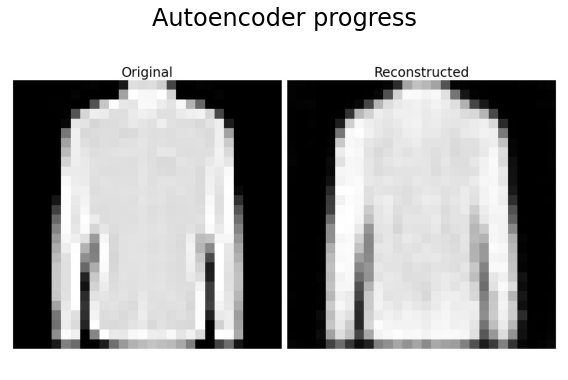

In [ ]:
def read_img(i):
    """
    Handles the exception caused by plots that were not saved because the
    model performance worsened on the respective epoch.
    """
    try:
        return mpimg.imread(
            f'models/best_AE_z{best_AE.latent_space}/plots/t={i}.jpg')
    except FileNotFoundError:
        return None

fig = plt.figure(figsize=(8,6), tight_layout='pad')
fig.suptitle('Autoencoder progress', fontsize=24)
plt.axis("off")
img_list = [read_img(i) for i in range(num_epochs)]

#Checks if element in img_list is an array, skips it in case it isn't.
ims = [[plt.imshow(i, animated=True)] 
       for i in img_list if type(i) == np.ndarray]
ani = animation.ArtistAnimation(
    fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [ ]:
with open('best_params.json', 'r') as f:
    params_dict = json.load(f)
best_params = {
    'conv1': {'filters': params_dict['filters1'],
                'kernel': 3,
                'stride': 2,
                'padding': 1},
    'conv2': {'filters': params_dict['filters2'],
                'kernel': 3,
                'stride': 2,
                'padding': 1},
    'conv3': {'filters': params_dict['filters3'],
                'kernel': 3,
                'stride': 2,
                'padding': 0},
    'lin1': params_dict['lin1'],
    'latent_space': params_dict['latent_space']
}

state_dict_best = torch.load(f'models/best_AE_z{params_dict["latent_space"]}/params/t18.pth')

#Instantiate the autoencoder
best_AE = vt.Autoencoder(28, best_params, device)
best_AE.load_state_dict(state_dict_best)
best_AE.to(device)

Autoencoder(
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=15, out_features=87, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=87, out_features=387, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=-1, unflattened_size=(43, 3, 3))
    (decoder_conv): Sequential(
      (0): BatchNorm2d(43, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ConvTranspose2d(43, 32, kernel_size=(3, 3), stride=(2, 2))
      (2): ReLU(inplace=True)
      (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ConvTranspose2d(32, 7, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): BatchNorm2d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ConvTranspose2d(7, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    )
  )
  (encoder): Encoder

# Denoising

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 1, 28, 28])) that is different to the input size (torch.Size([1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


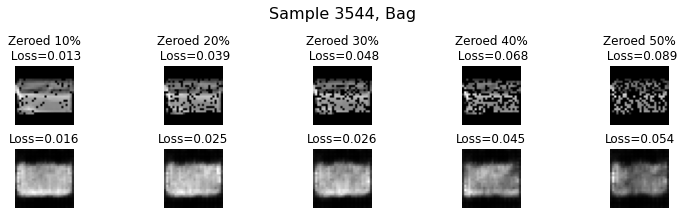

In [ ]:
#Draw random test sample
sample_idx = torch.randint(len(test_dataset), (1,))
sample, label = test_dataset[sample_idx.item()]

#Pixel-killing probabilites
p_list = [[.1,.9],[.2,.8],[.3,.7],[.4,.6],[.5,.5]]

#Set up the figure
fig, axs = plt.subplots(2, len(p_list), figsize=(11,3))

#Set up loss
losses = torch.zeros((len(p_list), 2),device=device)
loss_eval = nn.MSELoss()
loss_eval.to(device)

for i, ps in enumerate(p_list):
    sample.to(device)

    #Noise is added by zeroing pixels at random positions.
    noise_tensor = torch.from_numpy(
        np.random.choice([0,1], size=sample.size(), p=ps)
        )
    noisy_sample = sample*noise_tensor

    # Pass sample through autoencoder
    best_AE.eval()
    with torch.no_grad():
        cleanup = best_AE(noisy_sample.to(device).unsqueeze(0))
        losses[i,0] = loss_eval(noisy_sample, sample.unsqueeze(0))
        losses[i,1] = loss_eval(cleanup.cpu(), sample.unsqueeze(0))

    # Plot noisy and reconstructed sample side by side
    axs[0][i].imshow(noisy_sample.cpu().squeeze().float().numpy(), cmap='gray')
    axs[1][i].imshow(cleanup.cpu().squeeze().detach().numpy(), cmap='gray')
    axs[0][i].set_title(f'Zeroed {ps[0]*100:.0f}%\n Loss={losses[i,0].item():.3f}')
    axs[1][i].set_title(f'Loss={losses[i,1].item():.3f}')

    # Hide axis
    for ax in axs[:,i]:
        ax.axis('off')

#Aesthetic adjustments

fig.suptitle(
    f'Sample {sample_idx.item()}, {labels_map[label]}',
    fontsize=16
    )
fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.tight_layout(rect=(0,0,1,0.9),w_pad=1, h_pad=0.8)
fig.savefig('Reconstruction.pdf')
fig.show()

# Supervised learning on latent space

In [ ]:
class encoded_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_list):
        self.data = data_list[0]
        self.targets = data_list[1]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (self.data[idx], self.targets[idx])


def encode_data(dataloader, AE):
    enc_list = []
    label_list = []
    for sample_batched, labels in dataloader:
        label_list.append(labels)
        with torch.no_grad():
            AE.eval()
            sample_batched = sample_batched.to(AE.device)
            latent_vectors = AE.encoder(sample_batched)
            enc_list.append(latent_vectors)
    
    encoded_tensor  = torch.cat(enc_list)
    label_tensor = torch.cat(label_list)
    return [encoded_tensor, label_tensor]


encoded_train = encode_data(train_dataloader, best_AE)
encoded_test = encode_data(test_dataloader, best_AE)
enc_train_dataset = encoded_Dataset(encoded_train)
enc_test_dataset = encoded_Dataset(encoded_test)
enc_dataloader_train = DataLoader(enc_train_dataset, batch_size=256)
enc_dataloader_test = DataLoader(enc_test_dataset, batch_size=1)

In [ ]:
import time


class_params = {
    'lin1' : (best_AE.latent_space, 20),
    'lin2' : (20, 120),
    'lin3' : (120, 100),
    'lin4' : (100, 10),
}

classifier = vt.Classifier(class_params, device)
classifier.to(device)

classifier_loss = nn.CrossEntropyLoss()
classifier_loss.to(device)
optimizer = torch.optim.Adam(
    classifier.parameters(), lr=1e-4, weight_decay=1e-5
    )
no_epochs = 50

start_time = time.time()

loss = vt.train_model(
    classifier, enc_dataloader_train, enc_dataloader_test,
    no_epochs, classifier_loss, optimizer, encoded=True, verbose=False
    )

end_time = time.time()
training_time = end_time - start_time

print(f'Training took {training_time:.2f} seconds')
print(f'Final loss: {loss:.4f}')

Training took 232.43 seconds
Final loss: 0.5958


In [ ]:
class_params = {
    'lin1' : (28**2, 20),
    'lin2' : (20, 120),
    'lin3' : (120, 100),
    'lin4' : (100, 10),
}

classifier_noAE = vt.Classifier(class_params, device)

classifier_noAE.to(device)
classifier_noAE_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    classifier_noAE.parameters(), lr=1e-4, weight_decay=1e-5
    )
no_epochs = 50

start_time = time.time()

noAE_loss = vt.train_model(
    classifier_noAE, train_dataloader, test_dataloader,
    no_epochs, classifier_noAE_loss, optimizer, encoded=False, verbose=False
    )

end_time = time.time()

training_time = end_time - start_time

print(f'Training took {training_time:.2f} seconds')
print(f'Final loss: {noAE_loss:.4f}')

Training took 507.62 seconds
Final loss: 0.4265


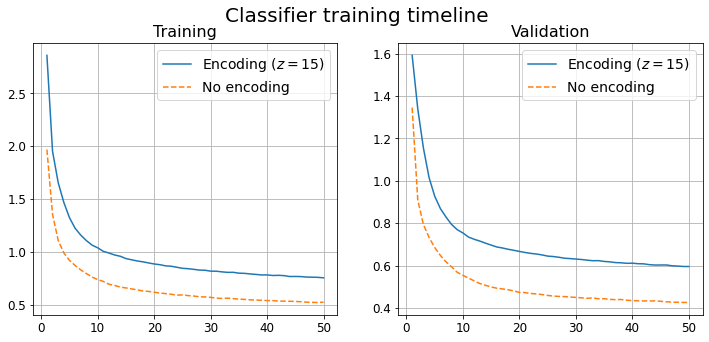

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12, 5))
model_list = [classifier, classifier_noAE]
label_list = [('-', f'Encoding $(z={best_AE.latent_space})$'), ('--', 'No encoding')]
for label, model in zip(label_list, model_list):
    axs[0].plot(model.history['epoch'], model.history['train'],
           label[0], label=label[1])
    axs[1].plot(model.history['epoch'], model.history['valid'],
        label[0], label=label[1])
    
axs[0].set_title('Training', fontsize=16)
axs[1].set_title('Validation', fontsize=16)
fig.suptitle(f'Classifier training timeline', fontsize=20)

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.legend(fontsize=14)
    ax.grid()


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3)
pca = PCA(n_components=3)

encoded_samples = []
samples = []
for sample in test_dataset:
    samples.append(sample[0].squeeze(0).flatten().cpu().numpy())
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    best_AE.encoder.eval()
    with torch.no_grad():
        encoded_img = best_AE.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"var_{i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)

encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
encoded_samples_reduced_TSNE = tsne.fit_transform(samples)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
import plotly.express as px

PCA_df = pd.DataFrame(encoded_samples_reduced_PCA, columns=['x1','x2','x3'])
PCA_df['label'] = [labels_map[label] for label in encoded_samples['label']]

TSNE_df = pd.DataFrame(encoded_samples_reduced_TSNE, columns=['x1','x2','x3'])
TSNE_df['label'] = PCA_df['label']

pca_plot = px.scatter_3d(PCA_df, x='x1', y='x2', z='x3', color='label')
tsne_plot = px.scatter_3d(TSNE_df, x='x1', y='x2', z='x3', color='label')

for (img, title) in zip([pca_plot, tsne_plot], ['PCA', 't-SNE']):
    img.update_layout(
        title=title,
        height=600, width=700,
        legend={'itemsizing': 'constant',
                'font' : dict(size=14)}
        )
    img.update_traces(marker=dict(size=1.2, line=dict(width=0.7)))

pca_plot.write_html("pca_plot.html")
tsne_plot.write_html("tsne_plot.html")

pca_plot.show()
tsne_plot.show()

# GAN

In [ ]:
n_classes = len(train_dataset.targets.unique())
params = {'latent_space' : 10,
          'G_filters' : 128,
          'D_filters' : 32,
          'n_channels' : 1,
          'opt' : 'Adam',
          'lr' : 1e-4}

gan_mm = vt.GAN(params, device)
gan_nonsat = vt.GAN(params, device)

In [ ]:
criterion = nn.BCEWithLogitsLoss() #Define loss

print('Minimax:')
loss_history_mm, img_list_mm = vt.train_GAN(
    gan_mm, train_dataloader, 30, criterion, device,
    saturating=True, snapshots = True) #train minimax gan
print("\n Non-saturating")
loss_history_nonsat, img_list_nonsat = vt.train_GAN(
    gan_nonsat, train_dataloader, 30, criterion, device,
    saturating=False, snapshots = True) #train nonsat gan

Minimax:
[30/30]	Loss_D: 0.1026, 	Loss_G: 4.4735, 	D(x):4.7142 	D(G(z)): -3.1831 / -4.4538 
 Non-saturating
[30/30]	Loss_D: 0.2266, 	Loss_G: 3.5598, 	D(x):3.4355 	D(G(z)): -2.7378 / -3.5082 

In [ ]:
class fakes_Dataset(torch.utils.data.Dataset):
    def __init__(self, fakes_tensor):
        self.data = fakes_tensor
        self.targets = torch.zeros(len(fakes_tensor))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

rand_noise = torch.randn(10000, gan_mm.latent_space, 1, 1, device=device)
gen_fakes = gan_mm.netG(rand_noise)

fakes_dataset = fakes_Dataset(gen_fakes)
fakes_dataloader = DataLoader(fakes_dataset, batch_size = 1)

In [ ]:
# Minimax
netD_loss_real = vt.test_netD(gan_mm, test_dataloader, criterion)   #loss on reals
netD_loss_fake = vt.test_netD(gan_mm, fakes_dataloader, criterion)  #loss on fakes

print(f"Discriminator loss (minimax) \n Real set: {netD_loss_real:.4f} \n Fake set: {netD_loss_fake:.4f}")

# Non-sat
netD_loss_real = vt.test_netD(gan_nonsat, test_dataloader, criterion)   #loss on reals
netD_loss_fake = vt.test_netD(gan_nonsat, fakes_dataloader, criterion)  #loss on fakes

print(f"Discriminator loss (non-saturating) \n Real set: {netD_loss_real:.4f} \n Fake set: {netD_loss_fake:.4f}")

Discriminator loss (minimax) 
 Real set: 0.7636 
 Fake set: 2.4547
Discriminator loss (non-saturating) 
 Real set: 0.8878 
 Fake set: 3.1830


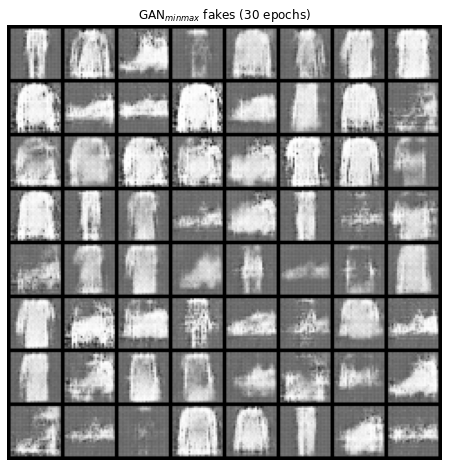

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.title('GAN$_{minmax}$ fakes (30 epochs)')
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), cmap='gist_gray', animated=True)] for i in img_list_mm]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

fig.savefig('gan_mm_fakes_30.pdf')

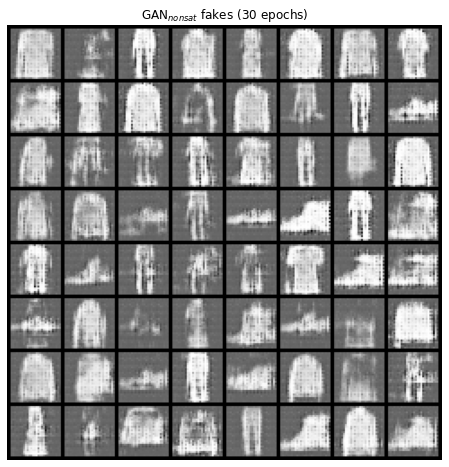

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.title('GAN$_{nonsat}$ fakes (30 epochs)')
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), cmap='gist_gray', animated=True)] for i in img_list_nonsat]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

fig.savefig('gan_ns_fakes_30.pdf')

In [ ]:
n_classes = len(train_dataset.targets.unique())
params = {'latent_space' : 10,
          'G_filters' : 128,
          'D_filters' : 32,
          'n_channels' : 1,
          'opt' : 'Adam',
          'lr' : 1e-4}

gan_mm = vt.GAN(params, device)
gan_nonsat = vt.GAN(params, device)

In [ ]:
criterion = nn.BCEWithLogitsLoss() #Define loss

print('Minimax:')
loss_history_mm, img_list_mm = vt.train_GAN(
    gan_mm, train_dataloader, 80, criterion, device,
    saturating=True, snapshots = True) #train minimax gan
print("\n Non-saturating")
loss_history_nonsat, img_list_nonsat = vt.train_GAN(
    gan_nonsat, train_dataloader, 80, criterion, device,
    saturating=False, snapshots = True) #train nonsat gan

Minimax:
[80/80]	Loss_D: 0.8747, 	Loss_G: 2.3636, 	D(x):0.3563 	D(G(z)): -2.3314 / -2.2014 
 Non-saturating
[80/80]	Loss_D: 1.1397, 	Loss_G: 1.3392, 	D(x):0.4273 	D(G(z)): -0.6121 / -0.9262 

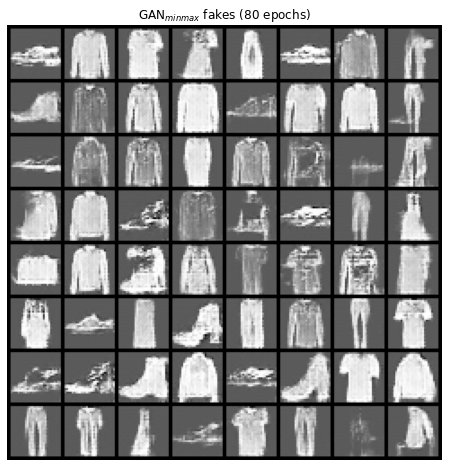

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.title('GAN$_{minmax}$ fakes (80 epochs)')
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), cmap='gist_gray', animated=True)] for i in img_list_mm]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

fig.savefig('gan_mm_fakes_80.pdf')

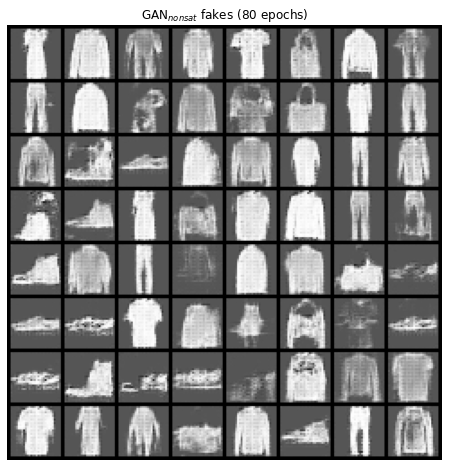

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.title('GAN$_{nonsat}$ fakes (80 epochs)')
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), cmap='gist_gray', animated=True)] for i in img_list_nonsat]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

fig.savefig('gan_ns_fakes_80.pdf')

In [ ]:
# Minimax
netD_loss_real = vt.test_netD(gan_mm, test_dataloader, criterion)   #loss on reals
netD_loss_fake = vt.test_netD(gan_mm, fakes_dataloader, criterion)  #loss on fakes

print(f"Discriminator loss (minimax) \n Real set: {netD_loss_real:.4f} \n Fake set: {netD_loss_fake:.4f}")

# Non-sat
netD_loss_real = vt.test_netD(gan_nonsat, test_dataloader, criterion)   #loss on reals
netD_loss_fake = vt.test_netD(gan_nonsat, fakes_dataloader, criterion)  #loss on fakes

print(f"Discriminator loss (non-saturating) \n Real set: {netD_loss_real:.4f} \n Fake set: {netD_loss_fake:.4f}")

Discriminator loss (minimax) 
 Real set: 0.5029 
 Fake set: 1.4158
Discriminator loss (non-saturating) 
 Real set: 0.5677 
 Fake set: 1.3403
